# Setup, matplotlib inline, automatically reload libraries on every evaluation

In [13]:
import pandas as pd
import numpy as np
import scipy as sp
pd.options.display.max_rows = 400
pd.options.display.max_columns = 400
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from loadcreon import LoadCreon
from creonmetrics import pu_scorer, prior_squared_error_scorer_015, brier_score_labeled_loss_scorer, \
    f1_assumed_scorer, f1_labeled_scorer, report_metrics, f1_assumed_beta10_scorer
from semisuperhelper import SemiSupervisedHelper
from pnuwrapper import PNUWrapper
from jeffsearchcv import JeffRandomSearchCV
from nestedcross import NestedCV, rerun_nested_for_estimator, rerun_nested_for_scoring
from frankenscorer import FrankenScorer, extract_scores_from_nested, extract_score_grid
from searchrf import save_search, load_search
from rfsubsample import RandomForestSubsample

In [15]:
path = "C:\Data\\010317\membership14_final_0103.txt"
lc = LoadCreon(path)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.base import clone

In [17]:
X_train, X_test, y_train, y_test = train_test_split(lc.X, lc.y, test_size=0.2, random_state=771, stratify=lc.y)

## Set up randomized search parameters

In [18]:
rf_param_search = {
 'base_estimator__target_imbalance_ratio': sp.stats.uniform(loc=0.1, scale=0.9),
 'base_estimator__class_weight': [None,'balanced','balanced_subsample'],
 'base_estimator__criterion': ['gini','entropy'],
 'base_estimator__max_depth': [None] + list(range(2,100)),
 'base_estimator__max_features': ['sqrt','log2',None] + list(range(5,100)),
 'base_estimator__min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,15,20,25,30,35,40,45,50,75,100],
 'base_estimator__min_samples_split':[2,0.005,0.01,0.015,0.02,0.025,0.03,0.035,0.04,
                                                        0.045,0.05,0.07,0.09,0.1,0.12,0.15,0.17,0.2,0.25],
 'base_estimator__n_estimators': sp.stats.randint(low=10, high=500),
 'pu_learning': [True, False],
                  }

## Set up PNU Wrapper with Random Forest, then JeffSearchCV, then NestedCV

In [21]:
pnu = PNUWrapper(base_estimator=RandomForestSubsample(verbose=1), random_state=42, num_unlabeled=1.0)

In [22]:
jeffsearch = JeffRandomSearchCV(pnu, rf_param_search, n_iter=100, scoring=FrankenScorer('pu_mix_assumed_f1beta10'),
                                n_jobs=-1, cv=3, verbose=1, pre_dispatch=8)

#### 3x3 (x100) nested cross validation

In [23]:
nested_cross = NestedCV(jeffsearch, scoring=FrankenScorer('pu_mix_assumed_f1beta10'),
                        cv=3, random_state=77, use_same_random_state=True)

## Score the nested cross - 900 models!

In [24]:
scores = nested_cross.score(X_train.values, y=y_train.values, verbose=1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 29.7min finished
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:   19.1s finished
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    7.0s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 29.1min finished
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:   19.5s finished
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    3.3s finished
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    6.9s finished
[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    6.9s finished


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 18.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 29.3min finished
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:   30.9s finished
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:    6.1s finished
[Parallel(n_jobs=1)]: Done 126 out of 126 | elapsed:    6.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 90.5min finished


## The scores of the 3 folds of the outer loop.  FrankenScorer for 100*f1beta=10 + PU

In [25]:
scores

(84.017749595502977, 81.627128860439228, 81.128808237031919)

In [26]:
save_search(nested_cross, './res/nested_cross_rfsubsample_large_20170219.pkl')

In [27]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                      0.0318473
assumed_brier_neg                                                  0.0310232
assumed_f1                                                           0.14016
assumed_f1beta10                                                    0.698797
confusion_matrix_lab       [[252.666666667, 34.6666666667], [132.0, 424.6...
confusion_matrix_un        [[111714.333333, 5247.66666667], [132.0, 424.6...
fn_confusion_matrix_lab                                                  132
fn_confusion_matrix_un                                                   132
fp_confusion_matrix_lab                                              34.6667
fp_confusion_matrix_un                                               5247.67
labeled_acc                                                         0.802512
labeled_avg_prec                                                    0.922386
labeled_brier                                                       0.164691

# Let's dive in and see the parameters for one of the best models

In [28]:
all_scores = [extract_score_grid(est) for est in nested_cross.estimators_]

In [29]:
best_clf_idx = [s.mean_pu_mix_assumed_f1beta10_test.idxmax() for s in all_scores]

In [30]:
[est.cv_results_['params'][best_idx] for est, best_idx in zip(nested_cross.estimators_, best_clf_idx)]

[{'base_estimator__class_weight': None,
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 63,
  'base_estimator__max_features': 89,
  'base_estimator__min_samples_leaf': 5,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 147,
  'base_estimator__target_imbalance_ratio': 0.31965354288726289,
  'pu_learning': False},
 {'base_estimator__class_weight': None,
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 63,
  'base_estimator__max_features': 89,
  'base_estimator__min_samples_leaf': 5,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 147,
  'base_estimator__target_imbalance_ratio': 0.31965354288726289,
  'pu_learning': False},
 {'base_estimator__class_weight': None,
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 90,
  'base_estimator__max_features': 72,
  'base_estimator__min_samples_leaf': 6,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimat

## Let's see what feature importance looks like for this specific estimator

In [ ]:
all_feature_importances = [est.best_estimator_.feature_importances_ for est in nested_cross.estimators_]
feature_importances = np.mean(all_feature_importances, axis=0)
feature_table = pd.DataFrame(feature_importances, index=X_test.columns).sort_values(by=0, ascending=False)

In [ ]:
feature_table

## Let's see what happens when use assumed_fbeta10 instead

In [31]:
nested_cross, new_estimators = rerun_nested_for_scoring(nested_cross, 'assumed_f1beta10', X=X_train.values, y=y_train.values,
                                        how='max', n_jobs=-1, verbose=1, return_estimators=True)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   57.2s finished


In [32]:
extract_scores_from_nested(nested_cross.test_score_datas_).mean().sort_index()

assumed_brier                                                      0.0368568
assumed_brier_neg                                                  0.0361766
assumed_f1                                                          0.126418
assumed_f1beta10                                                    0.713514
confusion_matrix_lab       [[250.333333333, 37.0], [118.333333333, 438.33...
confusion_matrix_un        [[111021.0, 5941.0], [118.333333333, 438.33333...
fn_confusion_matrix_lab                                              118.333
fn_confusion_matrix_un                                               118.333
fp_confusion_matrix_lab                                                   37
fp_confusion_matrix_un                                                  5941
labeled_acc                                                         0.815957
labeled_avg_prec                                                    0.925006
labeled_brier                                                        0.15198

In [33]:
all_scores = [extract_score_grid(est) for est in nested_cross.estimators_]

In [34]:
best_clf_idx = [s.mean_assumed_f1beta10_test.idxmax() for s in all_scores]

In [35]:
[est.cv_results_['params'][best_idx] for est, best_idx in zip(nested_cross.estimators_, best_clf_idx)]

[{'base_estimator__class_weight': None,
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 63,
  'base_estimator__max_features': 89,
  'base_estimator__min_samples_leaf': 5,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 147,
  'base_estimator__target_imbalance_ratio': 0.31965354288726289,
  'pu_learning': False},
 {'base_estimator__class_weight': None,
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 63,
  'base_estimator__max_features': 89,
  'base_estimator__min_samples_leaf': 5,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimators': 147,
  'base_estimator__target_imbalance_ratio': 0.31965354288726289,
  'pu_learning': False},
 {'base_estimator__class_weight': None,
  'base_estimator__criterion': 'entropy',
  'base_estimator__max_depth': 63,
  'base_estimator__max_features': 89,
  'base_estimator__min_samples_leaf': 5,
  'base_estimator__min_samples_split': 2,
  'base_estimator__n_estimat

In [36]:
all_feature_importances = [est.feature_importances_ for est in new_estimators]
feature_importances = np.mean(all_feature_importances, axis=0)
feature_table = pd.DataFrame(feature_importances, index=X_test.columns).sort_values(by=0, ascending=False)

In [37]:
feature_table

,0
DIAG_FLAG4_Sum,0.294609
DIAG_FLAG5_Sum,0.176075
ndc_cat58_Sum,0.046197
ndc_cat87_Sum,0.024148
age,0.023457
CPT_FLAG9_Sum,0.019586
DIAG_FLAG75_Sum,0.018839
CPT_FLAG43_Sum,0.013365
CPT_FLAG48_Sum,0.012776
DIAG_FLAG54_Sum,0.010007


## Lets see what unlabeled probability histogram looks like

In [38]:
probabs = nested_cross.estimators_[0].predict_proba(X_test.values)[:, 1]

[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    2.0s finished


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000BA39FD0>]], dtype=object)

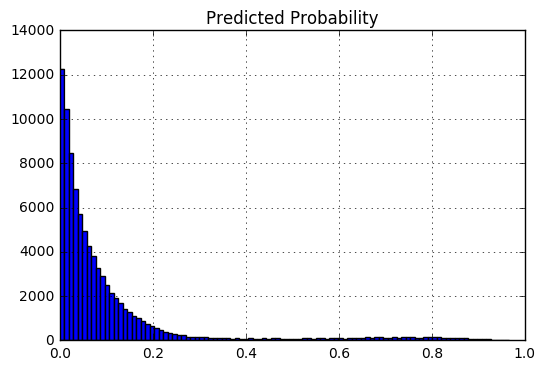

In [39]:
pd.DataFrame(probabs, columns=['Predicted Probability']).hist(bins=100)

In [40]:
new_probabs = new_estimators[0].predict_proba(X_test.values)[:, 1]

[Parallel(n_jobs=1)]: Done 147 out of 147 | elapsed:    2.1s finished


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C5EADA0>]], dtype=object)

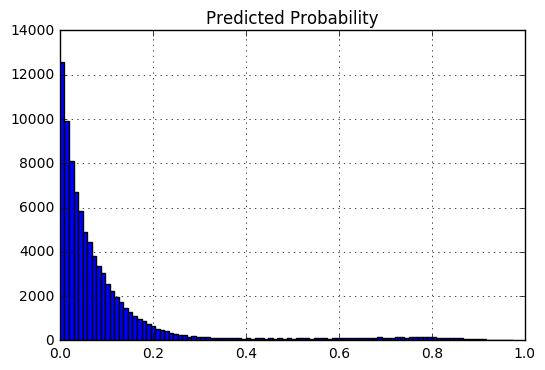

In [41]:
pd.DataFrame(new_probabs, columns=['Predicted Probability']).hist(bins=100)